# Development of SNAP for Mo

## 1. Data loading, Feature analysis and ML model training

### 1.1 Import necessary packages

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen.core import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### 1.2 Load DFT data

loadfn - loads json directly from a filename instead of a file-like object

In [2]:
Mo_train_data = loadfn('../data/Mo/training.json')
Mo_test_data = loadfn('../data/Mo/test.json')
print(' # of Mo training data: {}\n'.format(len(Mo_train_data)),
      '# of Mo test data: {}\n'.format(len(Mo_test_data)))

 # of Mo training data: 194
 # of Mo test data: 23



### 1.3 Bispectrum coefficients features

Transform each atom in structures to one array of feature, set pot_fit = False

Bispectrum coefficients used to describe the local environment of each atom. Lammps is required to perform this computation.

In [3]:
element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
per_atom_describer = BispectrumCoefficients(rcutfac=4.6, twojmax=6, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=False, 
                                                 include_stress=False)

Mo_train_structures = [d['structure'] for d in Mo_train_data]
per_atom_features = per_atom_describer.transform(Mo_train_structures)

print("Total # of atoms in Mo train: {}\n".format(sum([len(struct) for struct in Mo_train_structures])), 
      "     # of features generated: {} (one feature per atom)\n".format(per_atom_features.shape[0]),
      "     # of dimensions: {} (for twojmax = 6)".format(per_atom_features.shape[1]))

per_atom_features

Total # of atoms in Mo train: 10087
      # of features generated: 10087 (one feature per atom)
      # of dimensions: 30 (for twojmax = 6)


0-0-0    1-0-1     1-1-2    2-0-2    2-1-3     2-2-2  \
input_index                                                              
0           0   124.462  1.84799  0.263456  4.26455 -1.11603  0.326054   
            1   125.810  2.20039  0.208592  3.52869 -1.17388  0.218994   
            2   123.841  1.86081  0.270821  4.38266 -1.13467  0.338501   
            3   143.090  3.04986  0.373420  3.25778 -1.82603  0.270748   
            4   144.319  2.92569  0.320008  3.24895 -1.73175  0.275014   
...                 ...      ...       ...      ...      ...       ...   
193         49  136.250  3.10954  0.439348  3.63950 -2.06394  0.341287   
            50  136.357  3.11786  0.439819  3.63259 -2.06547  0.341753   
            51  136.872  3.10817  0.433644  3.57627 -2.04401  0.333398   
            52  136.132  3.15259  0.445036  3.62334 -2.08773  0.340179   
            53  137.204  3.13710  0.432743  3.49946 -2.04318  0.322604   

                   2-2-4    3-0-3    3-1-4    3-2-3  ...    5-0-5    5-1-6  \
input_index                                          ...                     
0           0   0.558607  70.6833 -3.37419  5.79846  ...  16.8842 -2.25530   
            1   0.698013  70.2654 -3.31556  6.08686  ...  16.6079 -1.91276   
            2   0.567762  70.6293 -3.37778  5.86068  ...  17.0931 -2.28501   
            3   0.724287  80.2995 -4.24534  6.55879  ...  13.7119 -2.95483   
            4   0.709205  79.1616 -4.14551  6.21897  ...  17.2148 -2.67167   
...                  ...      ...      ...      ...  ...      ...      ...   
193         49  0.918389  77.2291 -4.16682  7.27325  ...  11.8725 -3.36928   
            50  0.916988  77.3455 -4.17222  7.27420  ...  11.9340 -3.36258   
            51  0.910441  77.3208 -4.18267  7.21103  ...  11.7367 -3.33949   
            52  0.904702  78.0359 -4.16100  7.34505  ...  11.6832 -3.39334   
            53  0.879174  78.4212 -4.17879  7.22564  ...  11.4866 -3.33865   

                   5-2-5     5-3-6    5-4-5    5-5-6    6-0-6    6-2-6  \
input_index                                                              
0           0   0.948450   9.38008  1.43262  3.69807  122.085  1.71318   
            1   0.661440   9.16873  1.23632  3.35060  125.704  1.82725   
            2   0.977588   9.47510  1.45294  3.74500  121.228  1.78254   
            3   0.854494  10.26050  1.63928  3.29993  138.961  2.11681   
            4   0.869040  10.53210  2.14103  3.57158  139.051  1.65246   
...                  ...       ...      ...      ...      ...      ...   
193         49  0.995660  10.13260  1.18520  3.29885  132.169  2.59013   
            50  0.989725  10.15810  1.19801  3.28551  132.251  2.59820   
            51  0.975268  10.05800  1.18325  3.24985  132.906  2.52778   
            52  0.988255  10.28110  1.18348  3.29136  132.267  2.73167   
            53  0.953410  10.19330  1.19009  3.22081  133.546  2.62013   

                  6-4-6    6-6-6  
input_index                       
0           0   15.6665  14.3510  
            1   15.6754  15.2448  
            2   15.5571  14.3340  
            3   14.2842  17.8165  
            4   14.0439  17.8550  
...                 ...      ...  
193         49  13.9113  16.9846  
            50  13.8997  17.0423  
            51  14.0040  17.0294  
            52  13.8429  17.1861  
            53  13.9703  17.2668  

[10087 rows x 30 columns]

Transform each structure to one feature for structure and one feature for each atomic force component, set **pot_fit = True**

The dimension of features is 31 instead of 30. There is one extra intercept term at the beginning of the feature. This term is disminished for forces as the intercept disappears in the derivative of the energy.

In [4]:
element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
per_force_describer = BispectrumCoefficients(rcutfac=4.6, twojmax=6, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=True, 
                                                 include_stress=False)

Mo_train_structures = [d['structure'] for d in Mo_train_data]
per_force_features = per_force_describer.transform(Mo_train_structures)

print("Total # of features expected in Mo AIMD NPT: = {}\n".format(sum([(1 + 3 * len(struct)) for struct in Mo_train_structures])), 
      "     # of features generated: {} (1+3n features for n-atom structure)\n".format(per_force_features.shape[0]),
      "     # of dimensions: {}".format(per_force_features.shape[1]))

per_force_features

Total # of features expected in Mo AIMD NPT: = 30455
      # of features generated: 30455 (1+3n features for n-atom structure)
      # of dimensions: 31


Mo                                                       \
                    n       0-0-0     1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                  
0           0     1.0  136.513226  2.897633  0.330852   3.874669 -1.741448   
            0_x   0.0   -8.616920 -1.506620 -0.326711   5.227580  0.374775   
            0_y   0.0   -6.030820 -0.984749 -0.321555   4.931000  0.256769   
            0_z   0.0  -57.696700 -8.685780  0.300583  16.169700  0.422669   
            1_x   0.0   -7.680360 -1.391590 -0.314396   5.088870  0.341083   
...               ...         ...       ...       ...        ...       ...   
193         52_y  0.0    0.107620 -0.282543  0.132856   0.469175 -0.061844   
            52_z  0.0   -0.073829 -0.021861 -0.034001   0.288589  0.027024   
            53_x  0.0    0.922318  0.278364 -0.148138   0.266332  0.060279   
            53_y  0.0    0.237647 -0.108192  0.103442  -1.149000 -0.033458   
            53_z  0.0   -0.418131 -0.083721  0.130735   0.342733 -0.131350   

                                                           ...             \
                     2-2-2     2-2-4      3-0-3     3-1-4  ...      5-0-5   
input_index                                                ...              
0           0     0.288492  0.772622  76.418742 -3.903155  ...  16.542991   
            0_x   0.796144 -0.569053  -7.042660  1.815240  ...  74.724800   
            0_y   0.816798 -0.417896  -7.999780  1.836770  ...  69.158000   
            0_z   1.014170 -0.894816 -29.796700  1.330600  ...  90.265500   
            1_x   0.718836 -0.375692  -7.740140  1.814780  ...  75.446400   
...                    ...       ...        ...       ...  ...        ...   
193         52_y  0.070761 -0.006700  -1.054190 -0.326441  ...  -1.216370   
            52_z  0.017955 -0.071946  -1.146980  0.197229  ...   3.519480   
            53_x -0.085381  0.031781  -1.381360  0.490556  ...   2.274680   
            53_y -0.023422 -0.094774   4.100760 -0.328974  ... -12.611400   
            53_z  0.093246  0.096340  -0.629241 -0.412963  ...   1.604120   

                                                                       \
                     5-1-6     5-2-5      5-3-6      5-4-5      5-5-6   
input_index                                                             
0           0    -2.651726  0.892272  10.539150   1.904055   3.541988   
            0_x   1.768760  2.644930  13.689300  10.738700   9.659650   
            0_y   1.663180  2.625930  12.023400  10.041500   9.265660   
            0_z   0.374029  4.795130  11.484200   9.189340  13.451400   
            1_x   1.935220  2.220920  13.449200  11.055500   8.169640   
...                    ...       ...        ...        ...        ...   
193         52_y -0.450182  0.168347   0.262942  -0.255159   0.299007   
            52_z  0.137690  0.168821   0.483614   0.546709   0.680429   
            53_x  0.702681 -0.184682  -0.224138   0.429957  -0.240273   
            53_y -0.801992 -0.111669  -1.030790  -1.538940  -0.870637   
            53_z -0.292056  0.037334   0.453322   0.020536  -0.155703   

                                                              
                       6-0-6     6-2-6      6-4-6      6-6-6  
input_index                                                   
0           0     133.213547  2.204072  13.931770  17.639687  
            0_x   -39.511000 -2.474560 -12.242400   3.103400  
            0_y   -34.441400 -2.318850 -10.463200   2.314880  
            0_z  -118.835000 -2.141380 -19.041100 -12.900900  
            1_x   -40.595200 -2.825770 -12.227700   3.649260  
...                      ...       ...        ...        ...  
193         52_y    3.518370  0.448281   0.429999   0.941434  
            52_z   -0.429480 -0.211862   0.043644  -0.378821  
            53_x   -1.478440 -0.136570   0.779392  -0.609251  
            53_y    7.041580  0.381452   0.172993   1.236570  
     

### 1.4 Using PCA to visualize feature space

A reasonable set of structures for potential fitting tends to provide a good coverage of the feature space. However, 
distribution of features with 30 dimensions is impossible to visualize. We need to reduce the dimensions while maintaining most of the information. [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is one of the most important dimension reduction algorithms. PCA keeps the first two principal components which maximize the variances (information) between the features.

transform - transforms a list of objects to one or a list of pandas data frame/numpy ndarray

In [5]:
# Obtain structures from each categories
Mo_train_structures = [d['structure'] for d in Mo_train_data]
Mo_test_structures = [d['structure'] for d in Mo_test_data]

# Obtain the features from each categories
Mo_train_features = per_atom_describer.transform(Mo_train_structures)
Mo_test_features = per_atom_describer.transform(Mo_test_structures)

# Add up features
total_Mo_features = np.concatenate((Mo_train_features, Mo_test_features), axis=0)

# Fit the PCA
pca = PCA(n_components=2)
pca.fit(total_Mo_features)

Mo_train_pcs = pca.transform(Mo_train_features)
Mo_train_pc1 = Mo_train_pcs[:, 0]
Mo_train_pc2 = Mo_train_pcs[:, 1]

Mo_test_pcs = pca.transform(Mo_test_features)
Mo_test_pc1 = Mo_test_pcs[:, 0]
Mo_test_pc2 = Mo_test_pcs[:, 1]

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Visualization of PCA : x axis is the first principal component (PC1) and y axis is the second principal component (PC2).

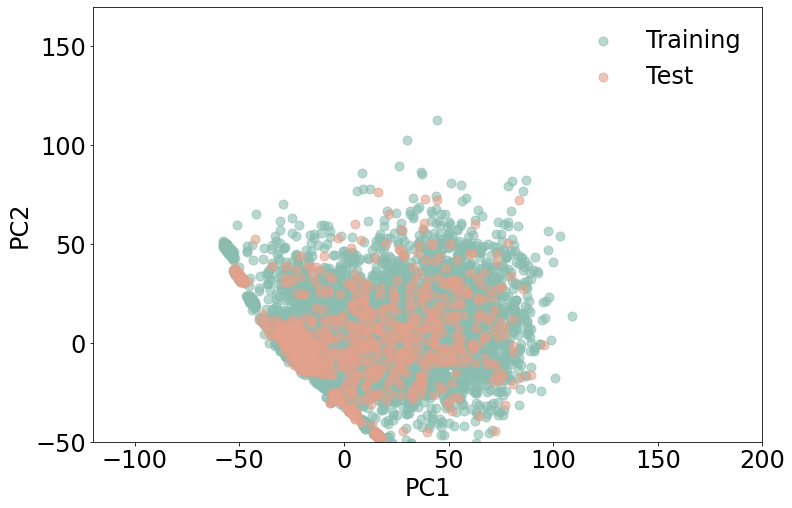

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(Mo_train_pc1, Mo_train_pc2, c='#8ABDB0', alpha=0.6, s=80, label='Training')
ax.scatter(Mo_test_pc1, Mo_test_pc2, c='#E2A18C', alpha=0.6, s=80, label='Test')

from matplotlib import ticker

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

plt.legend(fontsize=24, frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.xlim(-120, 200)
plt.ylim(-50, 170)

plt.savefig('images/Mo_pca.png', bbox_inches='tight')

### 1.5 Use the DFT-computed energy and forces as targets and train linear regression model

Split the dataset into three lists:
 - list of structure objects [Structure object for each structure]
 - list of energies [total_energy for each structure], 
 - list of forces [n x 3 forces array for each n-atom structure], n can be different for different structures.

In [8]:
Mo_train_structures = [d['structure'] for d in Mo_train_data]
Mo_train_energies = [d['outputs']['energy'] for d in Mo_train_data]
Mo_train_forces = [d['outputs']['forces'] for d in Mo_train_data]

print(" # of structures in Mo data: {}\n".format(len(Mo_train_structures)),
      "# of energies in Mo data: {}\n".format(len(Mo_train_energies)),
      "# of forces in Mo data: {}\n".format(len(Mo_train_forces)),
      "first item in energies: {}\n".format(Mo_train_energies[0]),
      "first item in forces: (n x 3 array)\n", np.array(Mo_train_forces[0]))

 # of structures in Mo data: 194
 # of energies in Mo data: 194
 # of forces in Mo data: 194
 first item in energies: -569.56177802
 first item in forces: (n x 3 array)
 [[ 0.62737967  0.61553514  0.50337361]
 [ 0.67928488  0.58991092  0.76121351]
 [ 0.65054693  0.57570951  0.56401081]
 [ 0.54840876  0.21804662  0.16336519]
 [ 0.60882331  0.42792014  1.33655269]
 [ 0.68577033  0.79876552  0.6083062 ]
 [ 0.56319211  1.39094233  0.44260005]
 [ 0.62786247  1.08193786  1.06348494]
 [ 0.63330399  0.5519824   0.53684184]
 [ 0.2733854   0.4937166   0.13868276]
 [ 0.56581201  0.47259556  1.41602091]
 [ 0.28082261  0.17723692  0.43231438]
 [ 0.48516324  0.39708736  0.40391853]
 [ 0.65788949  0.57806954  0.79926787]
 [ 0.54491509  1.43284949  0.43669104]
 [ 0.64512838  0.78845115  0.53246155]
 [ 0.79959939  0.7544561   0.7849406 ]
 [ 0.9189909   0.5574105   0.54849595]
 [ 1.54791437  0.49695549  0.49511264]
 [ 1.2594362   0.47463207  1.07042377]
 [ 1.51706925  0.54978822  0.46579914]
 [ 0.996303

Let's use the features with pot_fit = True, i.e., 1+3n features for n-atom structure

In [9]:
Mo_features = per_force_features
print("# of features generated: {}".format(Mo_features.shape[0]))
Mo_features

# of features generated: 30455


Mo                                                       \
                    n       0-0-0     1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                  
0           0     1.0  136.513226  2.897633  0.330852   3.874669 -1.741448   
            0_x   0.0   -8.616920 -1.506620 -0.326711   5.227580  0.374775   
            0_y   0.0   -6.030820 -0.984749 -0.321555   4.931000  0.256769   
            0_z   0.0  -57.696700 -8.685780  0.300583  16.169700  0.422669   
            1_x   0.0   -7.680360 -1.391590 -0.314396   5.088870  0.341083   
...               ...         ...       ...       ...        ...       ...   
193         52_y  0.0    0.107620 -0.282543  0.132856   0.469175 -0.061844   
            52_z  0.0   -0.073829 -0.021861 -0.034001   0.288589  0.027024   
            53_x  0.0    0.922318  0.278364 -0.148138   0.266332  0.060279   
            53_y  0.0    0.237647 -0.108192  0.103442  -1.149000 -0.033458   
            53_z  0.0   -0.418131 -0.083721  0.130735   0.342733 -0.131350   

                                                           ...             \
                     2-2-2     2-2-4      3-0-3     3-1-4  ...      5-0-5   
input_index                                                ...              
0           0     0.288492  0.772622  76.418742 -3.903155  ...  16.542991   
            0_x   0.796144 -0.569053  -7.042660  1.815240  ...  74.724800   
            0_y   0.816798 -0.417896  -7.999780  1.836770  ...  69.158000   
            0_z   1.014170 -0.894816 -29.796700  1.330600  ...  90.265500   
            1_x   0.718836 -0.375692  -7.740140  1.814780  ...  75.446400   
...                    ...       ...        ...       ...  ...        ...   
193         52_y  0.070761 -0.006700  -1.054190 -0.326441  ...  -1.216370   
            52_z  0.017955 -0.071946  -1.146980  0.197229  ...   3.519480   
            53_x -0.085381  0.031781  -1.381360  0.490556  ...   2.274680   
            53_y -0.023422 -0.094774   4.100760 -0.328974  ... -12.611400   
            53_z  0.093246  0.096340  -0.629241 -0.412963  ...   1.604120   

                                                                       \
                     5-1-6     5-2-5      5-3-6      5-4-5      5-5-6   
input_index                                                             
0           0    -2.651726  0.892272  10.539150   1.904055   3.541988   
            0_x   1.768760  2.644930  13.689300  10.738700   9.659650   
            0_y   1.663180  2.625930  12.023400  10.041500   9.265660   
            0_z   0.374029  4.795130  11.484200   9.189340  13.451400   
            1_x   1.935220  2.220920  13.449200  11.055500   8.169640   
...                    ...       ...        ...        ...        ...   
193         52_y -0.450182  0.168347   0.262942  -0.255159   0.299007   
            52_z  0.137690  0.168821   0.483614   0.546709   0.680429   
            53_x  0.702681 -0.184682  -0.224138   0.429957  -0.240273   
            53_y -0.801992 -0.111669  -1.030790  -1.538940  -0.870637   
            53_z -0.292056  0.037334   0.453322   0.020536  -0.155703   

                                                              
                       6-0-6     6-2-6      6-4-6      6-6-6  
input_index                                                   
0           0     133.213547  2.204072  13.931770  17.639687  
            0_x   -39.511000 -2.474560 -12.242400   3.103400  
            0_y   -34.441400 -2.318850 -10.463200   2.314880  
            0_z  -118.835000 -2.141380 -19.041100 -12.900900  
            1_x   -40.595200 -2.825770 -12.227700   3.649260  
...                      ...       ...        ...        ...  
193         52_y    3.518370  0.448281   0.429999   0.941434  
            52_z   -0.429480 -0.211862   0.043644  -0.378821  
            53_x   -1.478440 -0.136570   0.779392  -0.609251  
            53_y    7.041580  0.381452   0.172993   1.236570  
     

pool_from - Method to convert structures and their properties in to datapool format; ([dict]) returned

convert_docs - http://maml.ai/maml.utils.html?highlight=convert_docs#maml.utils.convert_docs

In [10]:
Mo_train_pool = pool_from(Mo_train_structures, Mo_train_energies, Mo_train_forces)
_, Mo_df = convert_docs(Mo_train_pool)
print("# of targets: ", len(Mo_df))
Mo_df

# of targets:  30455


,y_orig,n,dtype
0,-569.561778,53.0,energy
1,0.627380,1.0,force
2,0.615535,1.0,force
3,0.503374,1.0,force
4,0.679285,1.0,force
...,...,...,...
30450,-0.046170,1.0,force
30451,0.023323,1.0,force
30452,0.157114,1.0,force
30453,-0.156538,1.0,force


Create targets per atom (energy per atom = total_energies / num_atoms, force components per atom = $f_{x}$, $f_{y}$, $f_{z}$.

Use sklearn LinearRegression model to fit the features and targets, both simple linear model and weighted linear model are obtained

In [11]:
##### Simple Linear regression
y = Mo_df['y_orig']/Mo_df['n'] 
x = Mo_features

simple_model = LinearRegression()
simple_model.fit(x, y)

##### Increase the weights of energies since the number of forces are overwhelming
weights = np.ones(len(Mo_df['dtype']), )
weights[Mo_df['dtype'] == 'energy'] = 10000
weights[Mo_df['dtype'] == 'force'] = 1

weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=weights)

print("# of parameters in simple linear model: {}\n".format(len(simple_model.coef_)), 
      "parameters in simple linear model: \n", simple_model.coef_, "\n")
print("# of parameters in weighted linear model: {}\n".format(len(weighted_model.coef_)), 
      "parameters in weighted linear model: \n", weighted_model.coef_)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# of parameters in simple linear model: 31
 parameters in simple linear model: 
 [-1.63365461e+01  2.44374900e-02 -1.41568203e-02  6.16505701e-01
  1.62362566e-02  6.79358616e-01  1.27107066e-01  2.83797109e-01
  3.36322579e-02  2.90610502e-01  2.68569984e-01  1.07631271e-01
  2.49755331e-02 -2.30504668e-02  1.35457490e-02  1.62779653e-01
  8.96348623e-02  1.16198234e-01  2.09970128e-02 -1.18849289e-03
 -2.05493026e-02  1.51227477e-03  7.50605585e-02  6.32516899e-02
 -1.09617209e-03 -2.99624474e-03 -2.51810582e-02 -3.59369774e-03
  4.02542435e-02 -2.70489361e-03 -1.82944578e-03] 

# of parameters in weighted linear model: 31
 parameters in weighted linear model: 
 [-1.66937244e+01  2.44638946e-02  2.34907053e-02  6.10064651e-01
  1.76279670e-02  8.02703389e-01  1.27068342e-01  2.83093753e-01
  2.44562669e-02  2.80440419e-01  2.79258977e-01  1.25589068e-01
  5.52120711e-02 -1.67874708e-02  1.02664371e-02  1.51514385e-01
  9.60798430e-02  1.18819064e-01  4.56804550e-02  3.27979119e-03
 -

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Predict the energy and forces using fitted machine learning models, get the errors of energies and forces

In [12]:
energy_indices = np.argwhere(np.array(Mo_df["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(Mo_df["dtype"]) == "force").ravel()

simple_predict_y = simple_model.predict(x)
weighted_predict_y = weighted_model.predict(x)

original_energy = y[energy_indices]
original_forces = y[forces_indices]
simple_predict_energy = simple_predict_y[energy_indices]
simple_predict_forces = simple_predict_y[forces_indices]
weighted_predict_energy = weighted_predict_y[energy_indices]
weighted_predict_forces = weighted_predict_y[forces_indices]

print(" Simple model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, simple_predict_energy) * 1000),
      "Simple model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, simple_predict_forces)),
      "Weighted model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, weighted_predict_energy) * 1000),
      "Weighted model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, weighted_predict_forces)),)

 Simple model energy MAE: 29.171 meV/atom
 Simple model forces MAE: 0.176 eV/Å
 Weighted model energy MAE: 7.480 meV/atom
 Weighted model forces MAE: 0.183 eV/Å



/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## 2. Potential development & Materials Property Predictions

### 2.1 SNAP Potential development  

Wrap the bispectrum coefficients describer and linear regression model together. These are two inputs for the [SNAPotential](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_snap.py) object from maml package. Use the train() method of the SNAPotential. Three lists of respective structures, energies, and forces array are inputs for the train() method.

In [14]:
# Three lists of structures, energies, and forces array.
Mo_train_structures = [d['structure'] for d in Mo_train_data]
Mo_train_energies = [d['outputs']['energy'] for d in Mo_train_data]
Mo_train_forces = [d['outputs']['forces'] for d in Mo_train_data]
Mo_group = []
for i in range(len(Mo_train_data)):
    Mo_group.append(Mo_train_data[i]['group'])
Mo_num_atoms = [d['num_atoms'] for d in Mo_train_data]
Mo_groups = []
for i in range(len(Mo_train_data)): 
    Mo_groups = Mo_groups + [Mo_group[i]]*(1 + 3*Mo_num_atoms[i])

# Set the external weights.
Mo_train_pool = pool_from(Mo_train_structures, Mo_train_energies, Mo_train_forces)
_, Mo_df = convert_docs(Mo_train_pool)
Mo_df["group"] = Mo_groups
weights = np.ones(len(Mo_df['dtype']), )
weights[(Mo_df["dtype"] == "energy") & (Mo_df["group"] == "Elastic")] = 4868.530
weights[(Mo_df["dtype"] == "force") & (Mo_df["group"] == "Elastic")] =  98.477
weights[(Mo_df["dtype"] == "energy") & (Mo_df["group"] == "Surface")] = 1367.747
weights[(Mo_df["dtype"] == "force") & (Mo_df["group"] == "Surface")] =  0.340
weights[(Mo_df["dtype"] == "energy") & (Mo_df["group"] == "AIMD-NVT")] = 1376.755
weights[(Mo_df["dtype"] == "force") & (Mo_df["group"] == "AIMD-NVT")] =  2.613
weights[(Mo_df["dtype"] == "energy") & (Mo_df["group"] == "Vacancy")] =  2726.165
weights[(Mo_df["dtype"] == "force") & (Mo_df["group"] == "Vacancy")] =  8.045

# Initialize the bispectrum coefficients describer and linear regression model
element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
describer = BispectrumCoefficients(rcutfac=4.6, twojmax=6, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)
ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Mo_snap = SNAPotential(model=skl_model)

# Train the potential with lists of structures, energies, forces
Mo_snap.train(Mo_train_structures, Mo_train_energies, Mo_train_forces, sample_weight=weights)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### 2.2 Evaluate the energy and forces prediction

Use the fitted snap to evaluate energy and forces errors.

In [15]:
Mo_test_structures = [d['structure'] for d in Mo_test_data]
Mo_test_energies = [d['outputs']['energy'] for d in Mo_test_data]
Mo_test_forces = [d['outputs']['forces'] for d in Mo_test_data]

df_orig, df_predict = Mo_snap.evaluate(test_structures=Mo_test_structures, 
                                       test_energies=Mo_test_energies,
                                       test_forces=Mo_test_forces)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Draw the parity plots of energy and forces for Mo, the x axis is DFT computed values, the y axis is SNAP predicted values.

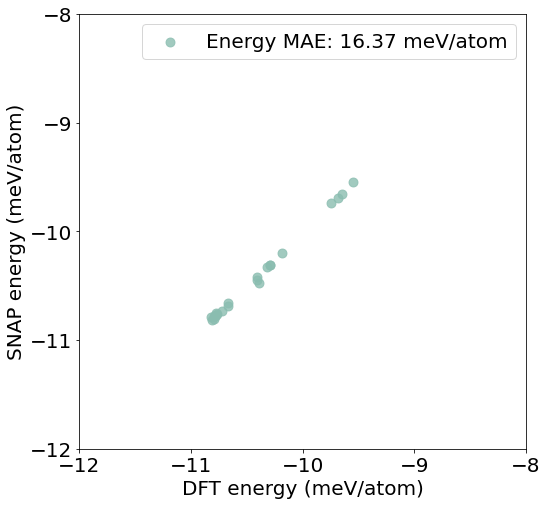

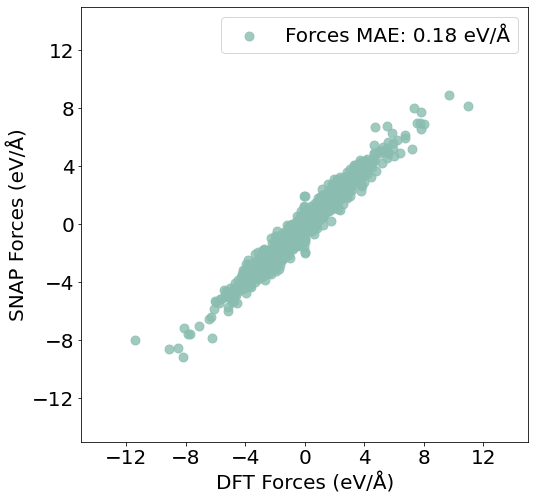

In [26]:
energy_indices = np.argwhere(np.array(df_orig["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(df_orig["dtype"]) == "force").ravel()
orig = df_orig['y_orig']/df_orig['n']
predict = df_predict['y_orig']/df_orig['n']

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(orig[energy_indices], predict[energy_indices], color='#8ABDB0', s=80, alpha=0.8, 
            label="Energy MAE: {:.2f} meV/atom".format(mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000))
ax1.set_xlim(-12, -8)
ax1.set_ylim(-12, -8)
ax1.set_xlabel("DFT energy (meV/atom)", fontsize=20)
ax1.set_ylabel("SNAP energy (meV/atom)", fontsize=20)
ax1.legend(fontsize=20)

from matplotlib import ticker

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))

fig, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(orig[forces_indices], predict[forces_indices], color='#8ABDB0', s=80, alpha=0.8,
            label="Forces MAE: {:.2f} eV/Å".format(mean_absolute_error(orig[forces_indices], predict[forces_indices])))
ax2.set_xlim(-15, 15)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("DFT Forces (eV/Å)", fontsize=20)
ax2.set_ylabel("SNAP Forces (eV/Å)", fontsize=20)
ax2.legend(fontsize=20)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(4))

In [23]:
mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000

16.365095535930337

In [25]:
mean_absolute_error(orig[forces_indices], predict[forces_indices])

0.17907288976648936

### 2.3 Predict basic properties

**1. lattice constants prediction** See [LatticeConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

inputs:
 - ff_settings: The potential object. Take SNAPotential as input here.

In [27]:
Mo_cell = Structure.from_spacegroup(sg='Im-3m', species=['Mo'], lattice=Lattice.cubic(3.17), coords=[[0, 0, 0]])

Mo_lc_calculator = LatticeConstant(Mo_snap)
a, b, c = Mo_lc_calculator.calculate([Mo_cell])[0]
print('Mo', 'Lattice a: {:.3f} Å, Lattice b: {:.3f} Å, Lattice c: {:.3f} Å'.format(a, b, c))

Mo Lattice a: 3.146 Å, Lattice b: 3.146 Å, Lattice c: 3.146 Å


**2. elastic constants prediction** See [ElasticConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 - atom_type: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).

In [28]:
Mo_ec_calculator = ElasticConstant(ff_settings=Mo_snap)
Mo_elastic_prop = Mo_ec_calculator.calculate(Mo_train_structures)
print('Mo', ' C11: {:.0f} GPa'.format(Mo_elastic_prop[0][0]), 'C12: {:.0f} GPa'.format(Mo_elastic_prop[0][1]),
      'C44: {:.0f} GPa'.format(Mo_elastic_prop[0][2]), 'Bulk Modulus: {:.0f}'.format(Mo_elastic_prop[0][3]))

Mo  C11: 471 GPa C12: 200 GPa C44: 75 GPa Bulk Modulus: 290


**3. Vacancy formation energy prediction** See [DefectFormation calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.

In [29]:
Mo_vacancy_calcualtor = DefectFormation(ff_settings=Mo_snap, specie='Mo', lattice='bcc', alat=3.16)
formation_energy = Mo_vacancy_calcualtor.calculate()
print('Mo Vacancy formation energy: {:.2f} eV'.format(formation_energy))

Mo Vacancy formation energy: 1.46 eV
